In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists

import torch
from torch.nn import CrossEntropyLoss
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torchinfo import summary

from util import test_loss_Unet, train_U_NET, plot_loss, plot_acc

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [3]:
batch_size = 3
image_size = (256, 256)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.CenterCrop(image_size)])

target_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(0.007843137718737125, 0.003921568393707275),transforms.CenterCrop(image_size), 
    transforms.Normalize(-1, 1)])

train_dataset = torchvision.datasets.OxfordIIITPet(root='./data/OxfordIIITPet', split="trainval", target_types="segmentation",
                                        download=True, transform=transform, target_transform=target_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.OxfordIIITPet(root='./data/OxfordIIITPet', split="test", target_types="segmentation",
                                        download=True, transform=transform, target_transform=target_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

input_shape = (batch_size, 3, image_size[0], image_size[1])

In [4]:
uniq = []
for img in train_dataset:
    uniq.extend(torch.unique(img[1]).numpy())
    uniq = np.unique(uniq).tolist()
    break
#uniq = np.array(uniq).astype(int)
print(uniq)

[-1.1920928955078125e-07, 1.0, 2.0]


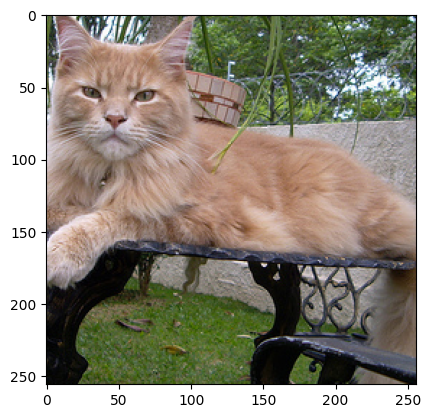

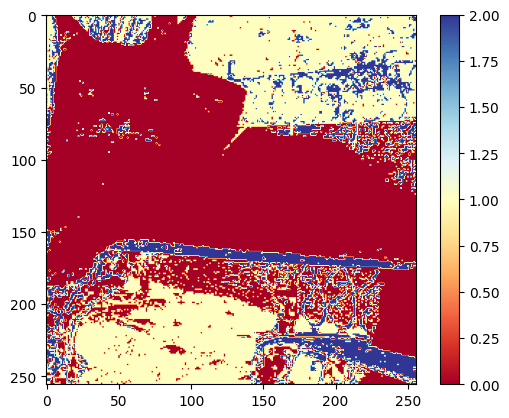

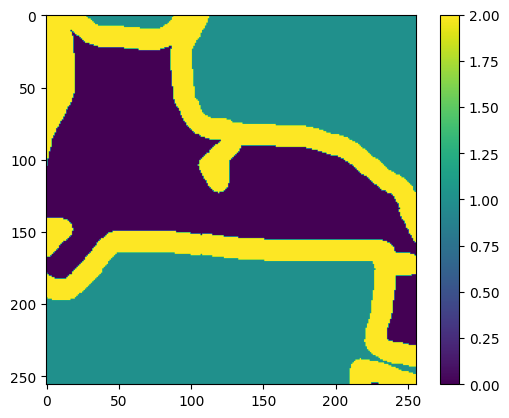

tensor(-1.1921e-07)


In [5]:
#print(train_dataset[2][0].shape)
img = torch.transpose(train_dataset[1000][0], 2,0)
img = torch.transpose(img, 1,0)
plt.imshow(img)
plt.show()

img_max = torch.argmax(train_dataset[1000][0], 0)
#img_max = torch.transpose(img_max, 2,0)
#img_max = torch.argmax(img_max, 2)
plt.imshow(img_max, cmap="RdYlBu")
plt.colorbar()
plt.show()

seg = torch.transpose(train_dataset[1000][1], 2,0)
seg = torch.transpose(seg, 1,0)
plt.imshow(seg)
plt.colorbar()
plt.show()
print(torch.min(seg))

In [4]:
from Models import U_Net

U_NN = U_Net(input_shape, output_channels=3, initial_lr=0.01, momentum=0.9, weight_decay=0)

summary(U_NN, input_shape)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [11]:
PATH = "./models/U_Net/U_NN.pth"

if exists(PATH):
    U_NN = torch.load(PATH)
    U_NN.eval()

U_Net(
  (NN): ModuleDict(
    (contr_1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (4): ReLU()
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (contr_2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (4): ReLU()
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (contr_3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): BatchNorm2d(256, eps=1e-05, moment

In [7]:
criterion = CrossEntropyLoss()
epochs = 1


train_U_NET(U_NN, criterion=criterion, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
        epochs=epochs, batches_to_test=600, patience=5, device=device, print_test=True, verbose=False, p_randomTransform=0.6)

In [9]:
print(U_NN.test_loss)

[]


In [12]:
torch.save(U_NN, "./models/U_Net/U_NN.pth")

In [5]:
U_NN = torch.load("./models/U_Net/U_NN.pth")

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

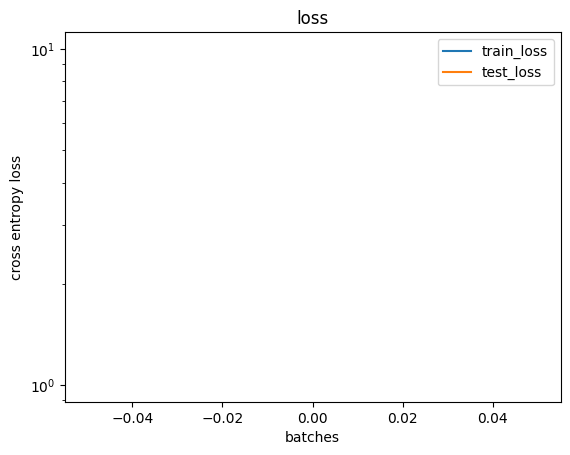

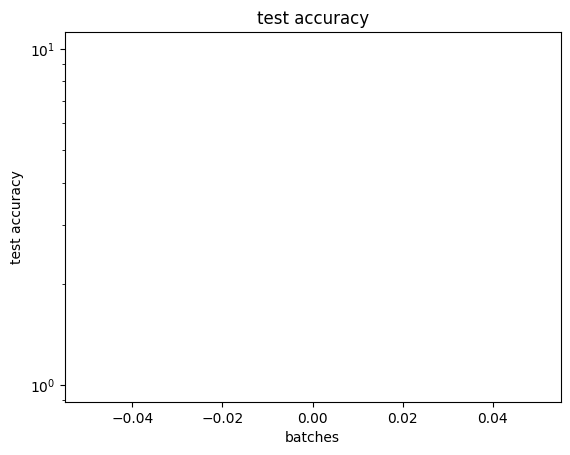

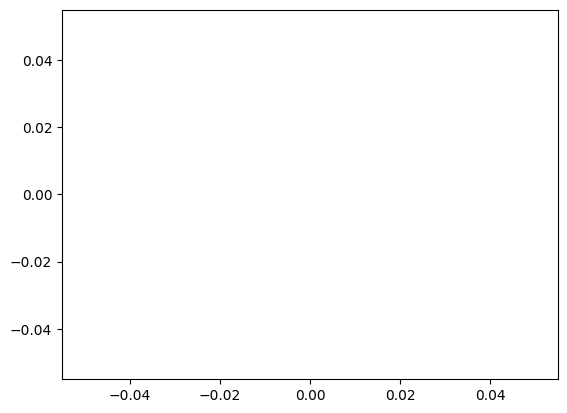

nan


/home/max/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/max/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
plot_loss(U_NN)
plot_acc(U_NN)

plt.plot(U_NN.train_time)
plt.show()
print(np.mean(U_NN.train_time))

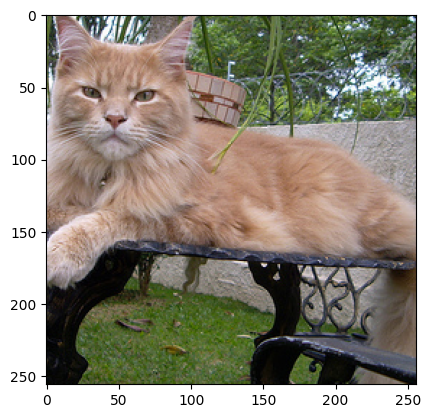

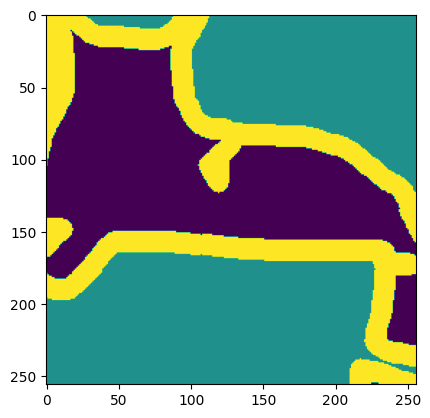

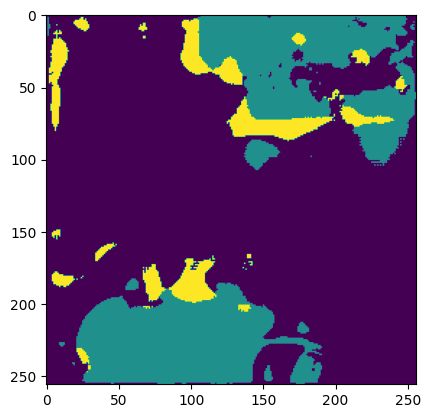

In [26]:
def show_segmentation_results(NN, dataset, index, device):
    img = torch.transpose(dataset[index][0], 2, 0)
    img = torch.transpose(img, 1,0)
    plt.imshow(img)
    plt.show()

    plt.imshow(dataset[index][1][0])
    plt.show()

    seg = dataset[index][0]
    seg = seg[None,:,:,:].to(device)
    outputs = NN(seg)
    outputs = torch.argmax(outputs, 1, keepdim=True)
    plt.imshow(outputs[0][0].detach().to("cpu").numpy())
    plt.show()

show_segmentation_results(U_NN, train_dataset, 1000, device)